# Data collapse

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [1]:
import os
import glob
import pickle
import datetime
# Our numerical workhorses
import numpy as np
import pandas as pd

import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as pch
import seaborn as sns

mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

## The Bohr parameter.

For the *lac* repressor we know that the fold-change in gene expression is given by

\begin{align}
\text{fold-change}(c) = \left( 1 + \frac{R}{N_{NS}} \cdot p_{act}(c) \cdot e^{-\beta \Delta \varepsilon_{RA}} \right)^{-1},
\tag{1}
\end{align}

where $R$ is the number of repressors, $N_{NS}$ is the number of non-specific sites to which the repressor can bind, $\Delta \varepsilon_{RA}$ is the binding energy of the repressor to the DNA binding site, $\beta$ is the inverse Boltzmann constant times the temperature, and $p_{act}$ is the probability of the repressor being active given a concentration of inducer $c$.

The functional form of this $p_{act}$ is given by the MWC model as

\begin{equation}
p_{act}(c) = \frac{\left( 1 + \frac{c}{K_A} \right)^2}{\left( 1 + \frac{c}{K_A} \right)^2 + e^{-\beta \Delta \varepsilon_{AI}}\left( 1 + \frac{c}{K_I} \right)^2},
\tag{2}
\end{equation}

where $K_A$ and $K_I$ are the dissociation constants of the repressor in the active and inactive state respectively and $\Delta \varepsilon_{AI}$ is the energetic difference between these two states. For the specific case of the *lac* repressor, being an inducible repressor we have that $K_A \geq K_I$ and $\Delta \varepsilon_{AI} \geq 0$.

To isolate the effect of the thermodynamic parameters we can re-write the fold-change equation as a Fermi potential, i.e.

\begin{equation}
\text{fold-change} = \frac{1}{1 + e^{-\beta F(c)}},
\end{equation}

where we have introduced the *Bohr parameter*,

\begin{equation}
F(c) = - k_BT \left( \log \frac{\left(1+\frac{c}{K_A}\right)^2}{\left(1+\frac{c}{K_A}\right)^2 + e^{-\beta \Delta\varepsilon_{AI} }\left(1+\frac{c}{K_I}\right)^2} + \log \frac{R}{N_{\text{NS}}} - \frac{\Delta\varepsilon_{RA}}{k_BT} \right).
\end{equation}

Let's first load  the data.

In [2]:
datadir = '../../data/'
df = pd.read_csv(datadir + 'flow_master.csv', comment='#')

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146
3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847
4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
5,20160804,mrazomej,O2,-13.9,RBS446,62,0.0,3854.650585,342.027265,0.021853
6,20160804,mrazomej,O2,-13.9,RBS1147,30,0.0,4169.802851,657.179531,0.041988


The values for the parameters we will use were determined [using MCMC](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/code/analysis/MCMC_parameter_estimation.ipynb) over all the O2 data sets, except for the HG104 strain.

In [4]:
# Load the flat-chain
with open('../../data/mcmc/main_text_KaKi.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
ea, ei, sigma = gauss_flatchain[max_idx]

Now let's define a function that takes a tidy `DataFrame` and computes the Bohr parameter.

In [5]:
def bohr_fn(df, ea, ei, epsilon=4.5):
    '''
    Computes the Bohr parameter for the data in a DataFrame df as a function
    of the MWC parameters ea and ei
    Parameters
    ----------
    df : DataFrame
        Pandas DataFrame containing all the data for which to calculate the bohr
        parameter
    ea, ei : float.
        Minus log of the dissociation constants of the active and the inactive 
        states respectively.
    epsilon : float.
        energy difference between the active and the inactive state.
    
    Returns
    -------
    bohr : array-like.
        Array with all the calculated Bohr parameters.
    '''
    bohr_param = []
    for i in range(len(df)):
        pact = mwc.pact_log(iptg=df.iloc[i].IPTG_uM, ea=ea, ei=ei,
                            epsilon=epsilon)
        F = -1 * (np.log(2 * df.iloc[i].repressors / 4.6E6)  +  np.log(pact) - \
                    df.iloc[i].binding_energy)
        bohr_param.append(F)
    return bohr_param

Now let's compute the Bohr parameter for the data.

In [6]:
df['bohr_1027'] = bohr_fn(df, ea, ei)

If this reparametrization holds true, all the data should collapse into a single master curve when plotting the fold change as a function of this Bohr parameter.

So let's look at the plot!

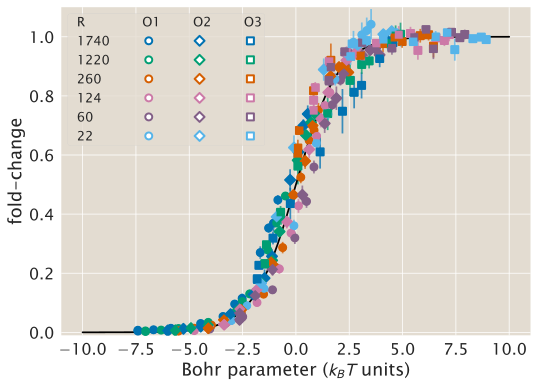

In [7]:
# Given this result let's plot all the curves using this parameters.
colors = sns.color_palette('colorblind', n_colors=8)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]
# Define the operators to use in the plot
operators = ['O1', 'O2', 'O3']
markers = ['o', 'D', 's']
F = np.linspace(-10, 10, 200)
plt.figure(figsize=(7.5, 5.5))
plt.plot(F, 1 / (1 + np.exp(-F)), '-', color='black')

# Instantiate the legend.
label_col = ['R', 1740, 1220, 260, 124, 60, 22]
label_O1 = ['O1']
label_O2 = ['O2']
label_O3 = ['O3']
label_empty = ['']
handles = []
for i, operator in enumerate(operators):
    data = df[df.operator==operator]
    for j, rbs in enumerate(df.rbs.unique()):
        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())
        bohr = data[data.rbs==rbs].groupby('IPTG_uM').bohr_1027.mean()
        plt.errorbar(bohr, fc_mean, yerr=fc_err, fmt=markers[i],
                    color=colors[j], label=None, markersize=8, alpha=0.75,
                    capsize=0)
        _p, = plt.plot(bohr, fc_mean, linestyle='none', marker=markers[i],
                      markeredgewidth=2, markeredgecolor=colors[j],
                      markerfacecolor='w', alpha=0.75)

        handles.append(_p)
plt.xlabel(r'Bohr parameter ($k_BT$ units)', fontsize=18)
plt.ylabel('fold-change', fontsize=18)
plt.ylim([-0.01, 1.1])

# Generate the legend handles. Extra is empty space.
extra = pch.Rectangle((0, 0), 1, 1, fill=False, edgecolor='none',
                      linewidth=0)
leg_handles = [extra, extra, extra, extra, extra, extra, extra]
slc = [0, 6, 12, 18]
for i in range(len(slc) - 1):
    leg_handles.append(extra)
    sel_handles = handles[slc[i]:slc[i + 1]]
    for j in range(len(sel_handles)):
        leg_handles.append(sel_handles[j])
labels = np.concatenate([label_col, label_O1, label_empty * 6, label_O2, label_empty * 6, label_O3, label_empty * 6])
plt.legend(leg_handles, labels, loc='upper left', ncol=4, fontsize=13,
           handletextpad=-1.5)
plt.tight_layout()
plt.tick_params(labelsize=16)